In [78]:
import networkx as nx
import pandas as pd
import numpy as np
import pydot
from networkx.drawing.nx_pydot import graphviz_layout


The csv file was created with based on a sample of a browser log from a previous paper:
```
zcat monitored-blr1-00.json.gz | head -n1 | jq -r '.http_trace | map(select(.message.message.method == "Network.requestWillBeSent") | .message.message.params | .initiator |= {"url", "type", "requestId"} | .request |= {"url", "method","headers"} | [.initiator.url, .request.url] ) | .[] |@csv' > /tmp/sample.csv
```


In [91]:
data = pd.read_csv("./sample-3.csv", header=None, names=["initiator", "referer", "url"]).fillna("user")
data

,initiator,referer,url
0,user,user,https://system1it.com/
1,https://system1it.com/,https://system1it.com/,https://fonts.googleapis.com/css?family=Open%2...
2,https://system1it.com/,https://system1it.com/,https://system1it.com/wp-includes/css/dist/blo...
3,https://system1it.com/,https://system1it.com/,https://system1it.com/wp-content/plugins/wooco...
4,https://system1it.com/,https://system1it.com/,https://system1it.com/wp-content/plugins/yith-...
...,...,...,...
92,https://system1it.com/,https://system1it.com/,https://www.google-analytics.com/r/collect?v=1...
93,user,https://system1it.com/,https://cdnjs.cloudflare.com/ajax/libs/jquery-...
94,user,https://system1it.com/wp-content/plugins/revsl...,https://system1it.com/wp-content/plugins/revsl...
95,user,https://system1it.com/,https://system1it.com/wp-content/plugins/revsl...


In [104]:
data["referer"].unique()

array(['user', 'https://system1it.com/',
       'https://fonts.googleapis.com/css?family=Open%20Sans%3A400%2C300%2C600%2C700%2C800%2C800italic%2C700italic%2C600italic%2C400italic%2C300italic%7CRoboto%3A400&subset=latin%2Clatin-ext&display=swap',
       'https://system1it.com/wp-content/themes/electro/assets/css/font-electro.css?ver=2.4.4',
       'https://system1it.com/wp-content/themes/electro/assets/vendor/fontawesome/css/all.min.css?ver=2.4.4',
       'https://system1it.com/wp-content/plugins/revslider/public/assets/css/rs6.css?ver=6.1.3'],
      dtype=object)

In [99]:
graph = nx.DiGraph(directed=True)
graph.add_edges_from(data[["referer", "url"]].to_numpy())

In [100]:
mapping = dict(zip(list(graph), range(len(list(graph)))))
mapping

{'user': 0,
 'https://system1it.com/': 1,
 'https://fonts.googleapis.com/css?family=Open%20Sans%3A400%2C300%2C600%2C700%2C800%2C800italic%2C700italic%2C600italic%2C400italic%2C300italic%7CRoboto%3A400&subset=latin%2Clatin-ext&display=swap': 2,
 'https://system1it.com/wp-includes/css/dist/block-library/style.min.css?ver=5.3.4': 3,
 'https://system1it.com/wp-content/plugins/woocommerce/packages/woocommerce-blocks/build/style.css?ver=2.5.11': 4,
 'https://system1it.com/wp-content/plugins/yith-woocommerce-wishlist/assets/css/jquery.selectBox.css?ver=1.2.0': 5,
 'https://system1it.com/wp-content/plugins/yith-woocommerce-wishlist/assets/css/font-awesome.min.css?ver=4.7.0': 6,
 'https://system1it.com/wp-content/plugins/yith-woocommerce-wishlist/assets/css/style.css?ver=3.0.5': 7,
 'https://system1it.com/wp-content/plugins/contact-form-7/includes/css/styles.css?ver=5.1.9': 8,
 'https://system1it.com/wp-content/plugins/revslider/public/assets/css/rs6.css?ver=6.1.3': 9,
 'https://system1it.com/w

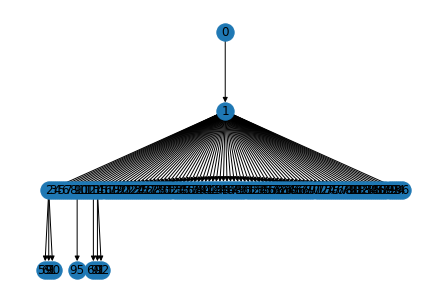

In [101]:
graph = nx.relabel_nodes(graph, mapping)
pos = graphviz_layout(graph, prog="dot")

nx.draw(graph, pos, with_labels=True)

In [105]:
import json

In [109]:
with open("./with-stack.json") as infile:
    deps = json.load(infile)
    display(deps)

[{'requestId': '5FCCBD54993F6B7A06E7EB9B6C1F99DD',
  'initiator': {'url': None,
   'type': 'other',
   'requestId': None,
   'stack': None},
  'request': {'url': 'https://system1it.com/',
   'method': 'GET',
   'headers': {'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/83.0.4103.0 Safari/537.36'}}},
 {'requestId': '3988.2',
  'initiator': {'url': 'https://system1it.com/',
   'type': 'parser',
   'requestId': None,
   'stack': None},
  'request': {'url': 'https://fonts.googleapis.com/css?family=Open%20Sans%3A400%2C300%2C600%2C700%2C800%2C800italic%2C700italic%2C600italic%2C400italic%2C300italic%7CRoboto%3A400&subset=latin%2Clatin-ext&display=swap',
   'method': 'GET',
   'headers': {'Referer': 'https://system1it.com/',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/83.0.4103.0 Safari/537.36'}}},
 {'requestId': '3988.3',
  'initiator': {'ur

In [146]:
edges = set()

for entry in deps:
    url = entry["request"]["url"]
    
    # Add an edge for the referer
    edges.add((entry["request"]["headers"].get("Referer", "User"), url))
    
    # Add an edge for the initiator if specified
    if entry["initiator"]["url"] != None:
        edges.add((entry["initiator"]["url"], url))
    
    # Add for each JS script that was traversed as they're indirect requirements
    if entry["initiator"]["stack"] != None:
        for stack_entry in entry["initiator"]["stack"]["callFrames"]:
            edges.add((stack_entry["url"], url))

edges

{('User', 'https://system1it.com/'),
 ('https://fonts.googleapis.com/css?family=Open%20Sans%3A400%2C300%2C600%2C700%2C800%2C800italic%2C700italic%2C600italic%2C400italic%2C300italic%7CRoboto%3A400&subset=latin%2Clatin-ext&display=swap',
  'https://fonts.gstatic.com/s/opensans/v17/mem5YaGs126MiZpBA-UN7rgOUuhp.woff2'),
 ('https://fonts.googleapis.com/css?family=Open%20Sans%3A400%2C300%2C600%2C700%2C800%2C800italic%2C700italic%2C600italic%2C400italic%2C300italic%7CRoboto%3A400&subset=latin%2Clatin-ext&display=swap',
  'https://fonts.gstatic.com/s/opensans/v17/mem5YaGs126MiZpBA-UNirkOUuhp.woff2'),
 ('https://fonts.googleapis.com/css?family=Open%20Sans%3A400%2C300%2C600%2C700%2C800%2C800italic%2C700italic%2C600italic%2C400italic%2C300italic%7CRoboto%3A400&subset=latin%2Clatin-ext&display=swap',
  'https://fonts.gstatic.com/s/opensans/v17/mem8YaGs126MiZpBA-UFVZ0b.woff2'),
 ('https://system1it.com/',
  'https://cdnjs.cloudflare.com/ajax/libs/jquery-mousewheel/3.1.13/jquery.mousewheel.min.js')

In [170]:
result = dict()

for source, target in edges:
    result.setdefault(target, []).append(source)
    
for key, values in result.items():
    if len(values) > 1:
        print(key, "\n", values)

https://system1it.com/wp-content/themes/electro/assets/vendor/fontawesome/webfonts/fa-solid-900.woff2 
 ['https://system1it.com/', 'https://system1it.com/wp-content/themes/electro/assets/vendor/fontawesome/css/all.min.css?ver=2.4.4']
https://system1it.com/wp-content/uploads/woos_search_engine_cache/guaven_woos_data.js?v=376.121 
 ['https://system1it.com/wp-includes/js/jquery/jquery.js?ver=1.12.4-wp', 'https://system1it.com/wp-content/plugins/woo-search-box/public/assets/guaven_woos.js?ver=376.121', 'https://system1it.com/']
https://system1it.com/wp-content/plugins/revslider/public/assets/assets/loader.gif 
 ['https://system1it.com/wp-content/plugins/revslider/public/assets/js/rs6.min.js?ver=6.1.3', 'https://system1it.com/wp-includes/js/jquery/jquery.js?ver=1.12.4-wp', 'https://system1it.com/wp-content/plugins/revslider/public/assets/css/rs6.css?ver=6.1.3', 'https://system1it.com/']
https://system1it.com/wp-content/plugins/revslider/public/assets/assets/transparent.png 
 ['https://syste

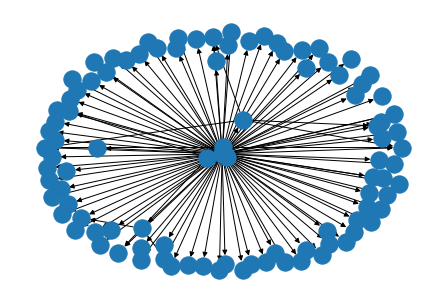

In [162]:
graph = nx.DiGraph()
graph.add_edges_from(edges)
pos = nx.spring_layout(graph)#graphviz_layout(graph, prog="twopi", root="User")
nx.draw(graph, pos, with_labels=False)